# 장고를 이용하여 게시판 앱 만들기

## 장고에서 null=True와 blank=True의 차이

* 필드(열)를 비워두는 것을 허용할 것인지를 설정하는데에서 차이점이 존재한다.
* null=True -> 필드의 값이 NULL로 저장되는 것을 허용. 즉, DB와 관련되어 있으며, 주어진 데이터베이스 컬럼이 null값을 가질 것인지 아닌지를 정의하는 옵션이다
* blank=True -> 필드가 폼에서 빈 채로 저장되는 것을 허용. 즉, 유효성과 관련되어 있으며, form.is_valid()가 호출될 때 폼 유효성 검사에 사용된다.

## 작성자 추가 및 표시하기

In [ ]:
# template/bbsnote/board_detail.list파일에 추가
# 추가위치는 <div class='card-text'>{{board. content}}</div>아래 부분에 작성
<div class="d-flex justify-content-end">
    <div class="badge badge-light p-2 text-left">
        <div class="mb-2">{{ board.author.username }}</div>
        <div>{{ board.create_date }}</div>
    </div>
</div>

In [ ]:
# 다음의 내용도 추가해준다
# 추가위치는 <span style="white-space: pre-line;">{{ comment.content }}</span> 아래 부분에 작성
<div class="d-flex justify-content-end">
    <div class="badge badge-light p-2 text-left">
        <div class="mb-2">{{ comment.author.username }}</div>
        <div>{{ comment.create_date }}</div>
    </div>
</div>

* 저장 후 웹사이트의 글을 확인해보면 아래와 같이 작성자와 작성일자가 표시된 것을 알 수 있다.

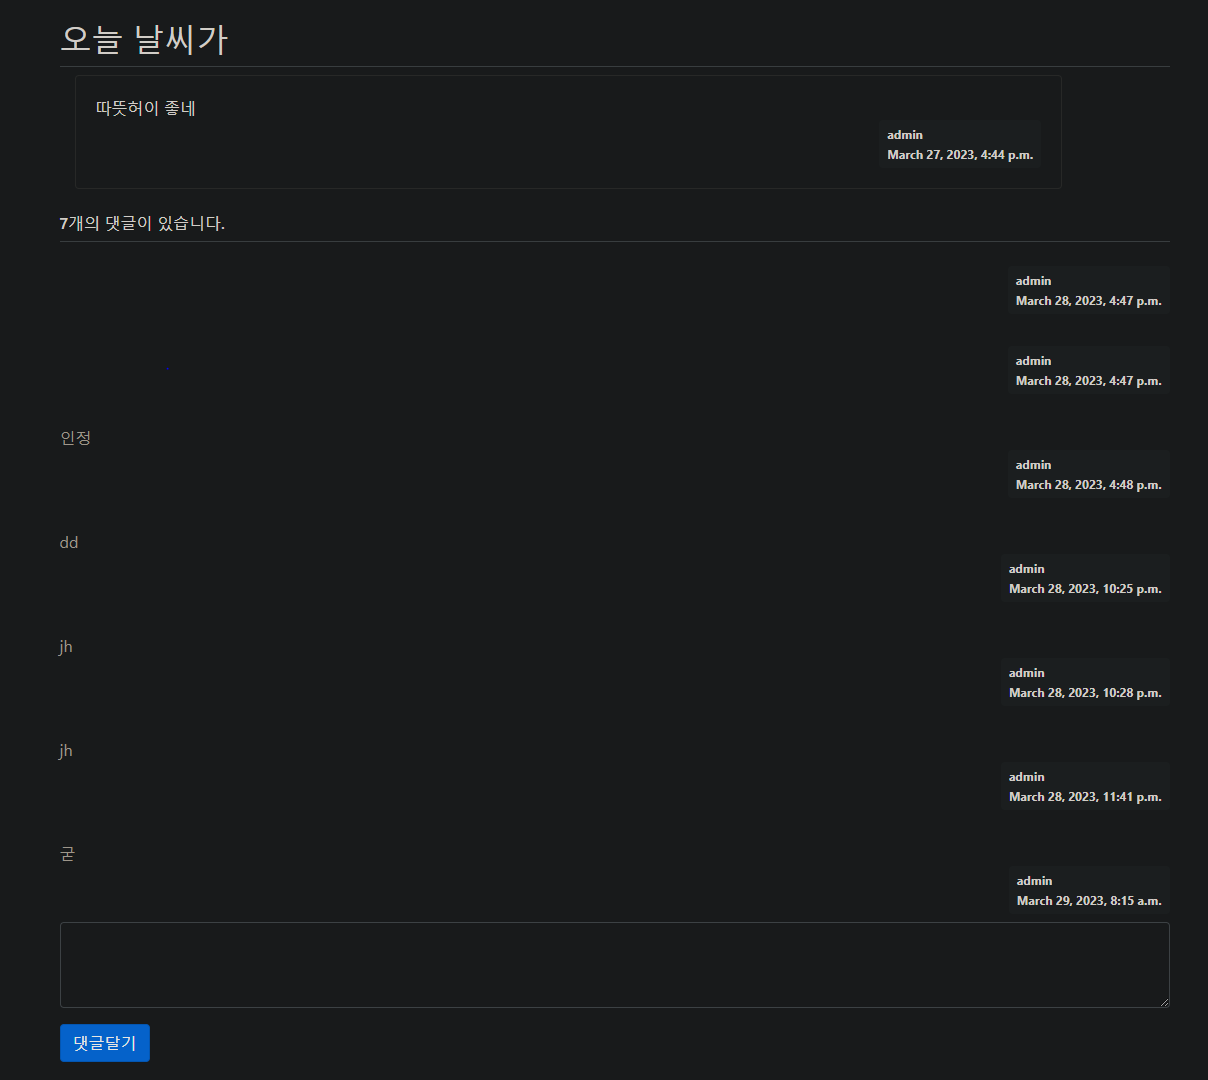

## GET방식과 POST방식

### GET방식과 POST방식의 비교
* GET방식은 보안과 관련 없는 간단한 데이터를 쉽게 전송할 수 있는 반면에 POST방식은 보안과 관련된 데이터를 전송하는데 많이 사용된다.

#### GET방식
* 데이터를 전송 시 데이터가 URL 뒤에 name=value 형태로 전송됨
* 여러 개의 데이터전송 시 & 로 구분해서 전송
* 보안에 취약
* 전송할 수 있는 데이터의 최대길이는 255자
* 기본 전송방식
* 웹 브라우저에 직접 입력해서도 전송 가능
* '/?page=2'와 같은 형태로 파라미터가 진행된다.

#### POST방식
* 데이터를 전송할 때 TCP/IP프로토콜 데이터의 HEAD 영역에 숨겨진 채 전송됨
* 보안에 유리
* 전송 데이터 용량이 무제한
* 전송 시 데이터를 또다시 가져오는 작업을 해야 하므로 처리속도가 GET방식보다 느림

## 게시물 수정 기능 추가하기

In [ ]:
# 수정을 위한 URL매핑추가를 해준다
urlpatterns = [
    path('', views.index, name='index'),
    path('<int:board_id>/', views.detail, name='detail'),
    path('comment/create/<int:board_id>/', views.comment_create, name='comment_create'),
    path('board/create/', views.board_create, name='board_create'),
    # 수정을 위한 url매핑
    path('board/modify/<int:board_id>/', views.board_modify, name='noard_modify'),
]

In [ ]:
# bbsnote/views.py파일에 수정을 위한 함수 생성
# 추가로 호출할 모듈
from django.shortcuts import render, redirect, get_object_or_404
from django.contrib import messages

# 함수 생성
@login_required(login_url='common:login')
def board_modify(request, board_id):
    # 오류가 나게 된다면 긴 글의 오류를 404오류로 대신 출력해준다
    board = get_object_ir_404(Board, pk=board_id)
    # 요청이 들어온 user와 board의 작성자가 틀리다면
    if request.user != board.author:
        # 요청이 들어온 user에게 오류메세지를 보내고 'bbsnote:detail'의 경로로 리다이렉트 시켜준다
        messages.error(request, '수정권한이 없습니다')
        return redirect('bbsnote:detail', board_id=board.id)
    # 수정이 POST방식으로 들어온 경우
    if requset.method == 'POST':
        form = BoardForm(request.POST, instance=board)
        if form.is_valid():
            board = form.save(commit=False)
            board.author = request.user
            board.save()
            return redirect('bbsnote:detail', board_id=board.id)
        # GET방식으로 넘어온 경우
        else:
            # instane매개변수에 board를 지정하면 기존의 값을 수정된 폼에 채울 수 있다.
            form = BoardForm(instance=board)
        # 템플릿에서 사용할 수 있는 데이터를 포함하는 딕셔너리
        context = {'form': form}
        # 요청에 대해 'bbsnote/board_form.html'의 내용을 랜더링하여 context출력
        return render(request, 'bbsnote/board_form.html', context)

* message 모듈을 이용하여 '수정권한이 없습니다'라는 오류 발생. 오류를 임의로 발생시키고 싶은 경우 사용
* get_object_or_404 - 모델의 기본키를 이용하여 모델 객체 한 건을 반환. 해당하는 건이 없으면 오류 대신 404페이지를 반환
* form = BoardForm(insatance=board) instance 매개변수에 board를 지정하면 기존 값을 폼에 채울 수 있다.

* 예를 들어 수정페이지에서 admin으로 로그인 되어있는 상태일 때, 작성자가 admin이 아닌 다른 작성자의 링크로 접속하게 된다면 페이지오류가  아래와 같이 나오도록 만들어진 것이다.

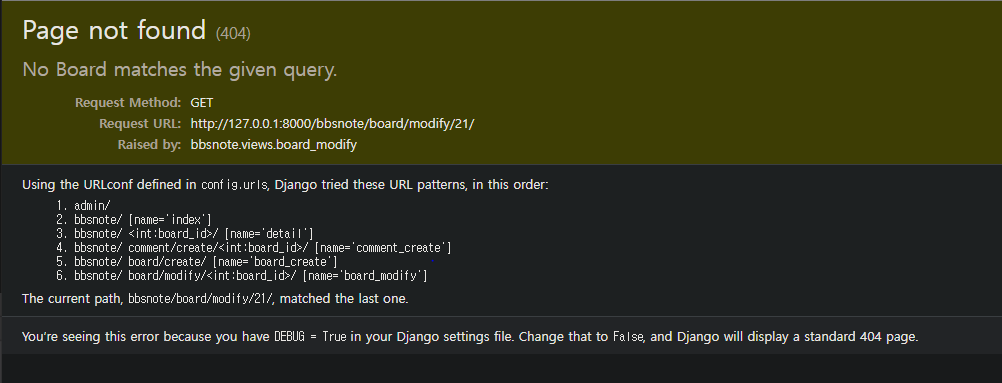

* 이부분에서 message가 화면에 나타나도록 코드를 덧붙여준다.

In [ ]:
# <div class="container my-3"> 아래부분에 추가
{% if messages %}
<div class="alert alert-danger my-3" role="alert">
    {% for message in messages %}
    <strong>{{ message.tags }}</strong>
    <ul>
        <li>{{ message.message }}</li>
    </ul>
    {% endfor %}
</div>
{% endif %}

* 코드를 저장 후 앞서서 실행했던 수정페이지 url에서 다른 작성자의 게시글URL로 접근하게 되면 아래와 같이 메세지가 나오게 된다.

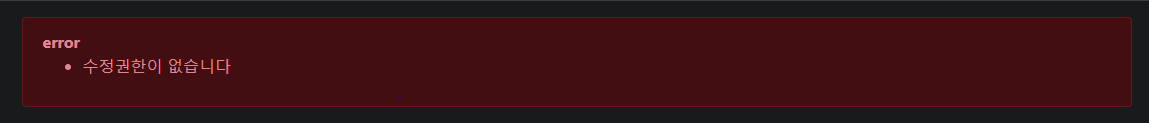

In [ ]:
# template/bbsnote/board_detail.html파일에 수정버튼과 수정일자를 표시
# <div class="d-flex justify-content-end">아래에 추가
{% if board.update_date %}
<div class="badge badge-light p-2 text-left mx-3">
    <div class="mb-2">modified at</div>
    <div>{{ board.update_date }}</div>
</div>
{% endif %}

# <div>{{ board.create_date }}</div> 아래에 추가
{% if request.user == board.author %}
<div class="my-3">
    <a href="{% url 'bbsnote:board_modify' board.id  %}" class="btn btn-sm btn-outline-secondary">수정</a>
</div>

* 이제 수정날짜까지 나타나는 것을 알 수 있다.

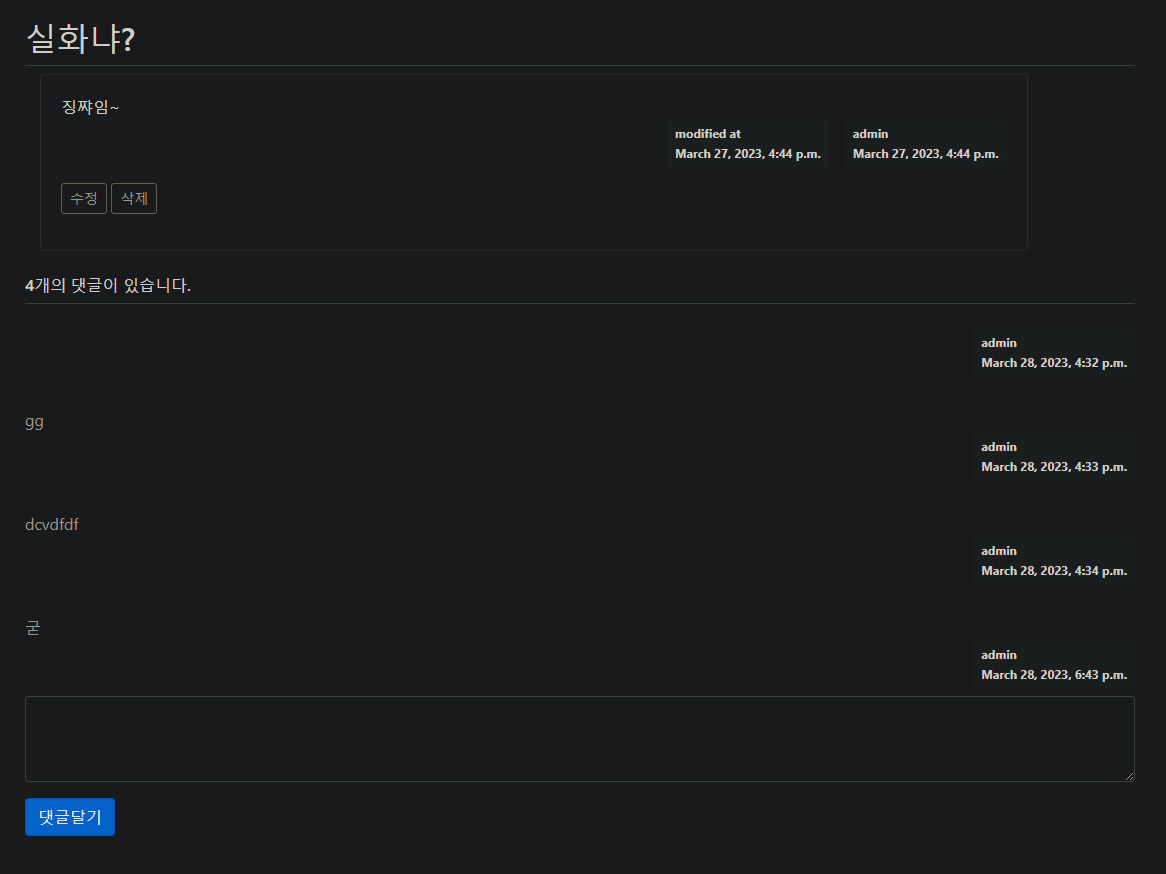

## 게시물 삭제 기능 추가하기

In [ ]:
# bbsnote/views.py에 삭제를 위한 URL매핑을 추가
urlpatterns = [
    path('', views.index, name='index'),
    path('<int:board_id>/', views.detail, name='detail'),
    path('comment/create/<int:board_id>/', views.comment_create, name='comment_create'),
    path('board/create/', views.board_create, name='board_create'),
    # 수정을 위한 url매핑
    path('board/modify/<int:board_id>/', views.board_modify, name='board_modify'),
    # 삭제를 위한 url매핑
    path('board/delete/<int:board_id>/', views.board_delete, name='board_delete'),
]

In [ ]:
# bbsnote/views.py파일에 삭제를 위한 함수를 생성
@login_required(login_url='common:login')
def board_delete(request, board_id):
    board = get_object_or_404(Board, pk=board_id)
    if request.user != board.author:
        messages.error(request, '삭제 권한이 없습니다')
        return redirect('bbsnote:detail', board_id=board.id)
    board.delete()
    return redirect('bbsnote:index')

* 삭제 버튼 추가 및 삭제 선택 시 한 번 더 확인을 위해 질문하는 jQuery를 추가해준다.

In [ ]:
# templates/bbsnote/board_detail.html파일에 추가
<div class="my-3">
    <a href="{% url 'bbsnote:board_modify' board.id %}" class="btn btn-sm btn-outline-secondary">수정</a>
    <a href="#" class="delete btn btn-sm btn-outline-secondary" data-uri="{% url 'bbsnote:board_delete' board.id %}">삭제</a>
</div>

In [ ]:
# templates/bbsnote/board_detail.html파일하단 {%endblock%}부분 아래에 jquery문 추가
{% block script %}
<script type="text/javascript">
    $(document).ready(function() {
        // delete로 명시된 부분에 클릭이벤트가 발생되면 아래 function을 실행
        $(".delete").on("click", function() {
            if(confirm("정말로 삭제하시겠습니까?")) {
                // this=나 자신을 뜻함 -> 현재 돔구성 안에서 데이터가 url로 되어있는 위치로 이동
                location.href = $(this).data('uri');
            }
        });
    });
</script>
{% endblock %}

* 코드를 저장하고 웹사이트에 가서 새로고침을 한 뒤 화면에 아래와 같이 게시글 부분에 수정 및 삭제 버튼이 생기며, 게시글을 삭제할 경우 안내메시지가 나오면서 삭제가 올바르게 실행되는 것을 알 수 있다.

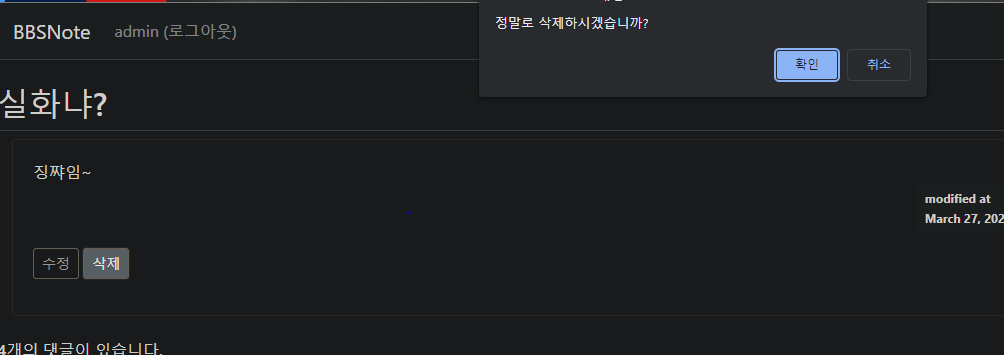

## 게시글의 댓글 수 표시 및 날짜 포맷 변경하기

In [ ]:
# templates/bbsnote/board_list.html에 다음을 추가해준다
# 날짜 포맷 변경
{{ board.create_date|date:'Y-m-d A h:i' }}

In [ ]:
# config/settings.py파일에서 language_code 옵션을 한글로 변경
LANGUAGE_CODE = "ko-KR"

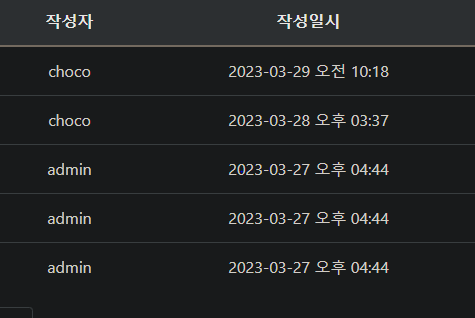

In [ ]:
# 게시글의 댓글 수 옵션 추가
# <a href="{% url 'bbsnote:detail' board.id %}"> 아래 부분에 추가
{{board.subject}}
{% if board.comment_set.count > 0 %}
<span class="text-danger small ml-2">
    [{{board.comment_set.count}}]
</span>
{% endif %}

* 게시글의 댓글 수도 잘 나오는 것을 알 수 있다.

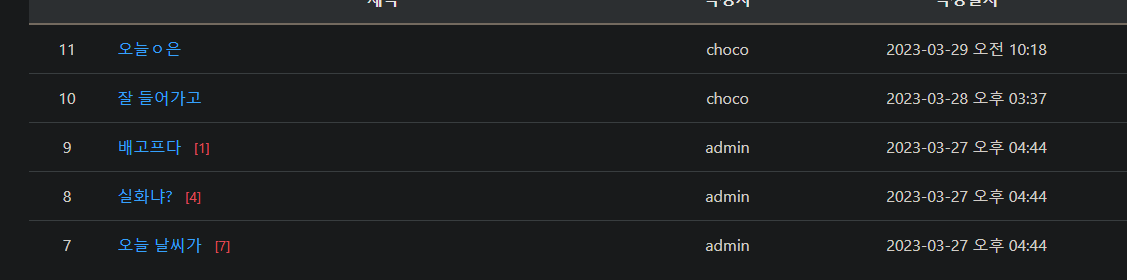

## 댓글 수정기능 추가하기

In [ ]:
# bbsnote/views.py댓글 수정을 위한 URL매핑 추가
urlpatterns = [
    path('', views.index, name='index'),
    path('<int:board_id>/', views.detail, name='detail'),
    path('comment/create/<int:board_id>/', views.comment_create, name='comment_create'),
    path('board/create/', views.board_create, name='board_create'),
    path('board/modify/<int:board_id>/', views.board_modify, name='board_modify'),
    path('board/delete/<int:board_id>/', views.board_delete, name='board_delete'),
    # 댓글 수정을 위한 url매핑 추가
    path('comment/modify/<int:comment_id>/', views.comment_modify, name='comment_modify'),
]

In [ ]:
# bbsnote/views.py파일에 댓글 수정을 위한 함수 생성
from .forms import BoardForm, CommentForm

@login_required(login_url='common:login')
def comment_modify(request, comment_id):
    comment = get_object_or_404(Comment, pk=comment_id)
    # 요청들어온 정보의 user와 comment작성자가 다르면
    if request.user != comment.author:
        messages.error(request, '수정권한이 없습니다')
        return redirect('bbsnote:detail', board_id=comment.board.id)
    if request.method == 'POST':
        form = CommonForm(request.POST, instance=comment)
        if form.is_valid():
            comment = form.save(commit=False)
            comment.author = request.user
            comment.save()
            return redirect('bbsnoteLdetail', board_id=comment.board.id)
    # 요청이 GET방식일때
    else:
        form = CommonFomrm(instance=comment)
    context = {'comment': comment, 'form': form}
    return render(request, 'bbsnote/comment_form.html', context)

In [ ]:
# bbsnote/forms.py파일에 CommentForm클래스 선언
from bbsnote.models import Board, Comment

class CommentForm(forms.ModelForm):
    class Meta:
        model = Comment
        fields = ['content']
        labels = {
            'content': '댓글내용'
        }

In [ ]:
# templates/bbsnote의 경로에 comment_form.html파일을 생성하고 댓글 수정 폼을 만들어준다
{% extends 'base.html' %}
{% block content %}
<div class="container my-3">
    <h5 class="border-bottom pb-2">댓글등록하기</h5>
    <form method="post" class="post-form my-3">
        {% csrf_token %}
        {% include "form_errors.html" %}
        <div class="form-group">
            <label for="content">댓글내용</label>
            <textarea class="form-control" name="content" id="content"
                rows="3">{{ form.content.value|default_if_none:'' }}</textarea>
        </div>
        <button type="submit" class="btn btn-primary">저장하기</button>
    </form>
</div>
{% endblock %}

* 수정 링크 추가와 수정일자를 표시하기 위해 html파일을 수정해준다.

In [ ]:
# templates/bbsnote/board_detail.html파일에 다음 내용 추가
# <span style="white-space: pre-line;">{{ comment.content }}</span> 아래에 작성
{% if request.user == comment.author %}
<a href="{% url 'bbsnote:comment_modify' comment.id %}" class="small">수정</a>
{% endif %}

* 코드 저장 이후 게시글에 들어가면 '수정'버튼이 생기고 수정버튼을 누른뒤, 내용을 수정해주면 된다.

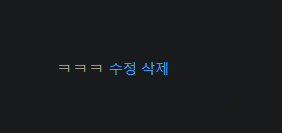

## 댓글 삭제 기능 추가하기

In [ ]:
# 댓글 삭제을 위한 URL매핑 추가
urlpatterns = [
    path('', views.index, name='index'),
    path('<int:board_id>/', views.detail, name='detail'),
    path('comment/create/<int:board_id>/', views.comment_create, name='comment_create'),
    path('board/create/', views.board_create, name='board_create'),
    path('board/modify/<int:board_id>/', views.board_modify, name='board_modify'),
    path('board/delete/<int:board_id>/', views.board_delete, name='board_delete'),
    path('comment/modify/<int:comment_id>/', views.comment_modify, name='comment_modify'),
    path('comment/delete/<int:comment_id>/', views.comment_delete, name='comment_delete'),
]

In [ ]:
# bbsnote/views.py파일에 댓글 삭제를 위한 함수 생성
@login_required(login_url='common:login')
def comment_delete(request, comment_id):
    comment = get.object_or_404(Comment, pk=comment_id)
    if request.user != comment.author:
        messages.error(request, '삭제 권한이 없습니다')
        return redirect('bbsnote:detail', board_id=comment.id)
    comment.delete()
    return redirect('bbsnote:detail', board_id=comment.board.id)

In [ ]:
# templates/bbsnote/board_detail.html파일에 다음 내용 추가
# <span style="white-space: pre-line;">{{ comment.content }}</span> 아래 수정 버튼 다음에 작성
{% if request.user == comment.author %}
<a href="{% url 'bbsnote:comment_modify' comment.id %}" class="small">수정</a>
<a href="#" class="small delete" data-uri="{% url 'bbsnote:comment_delete' comment.id %}">삭제</a>
{% endif %}

* 댓글을 삭제하려고 하면, 게시글과 마찬가지로 아래와 같은 문구가 나타나게 되는데 그 이유는, 우리가 jQuery를 생성할때 .delete라는 클래스로 선언했기 때문에 댓글의 삭제버튼에도 동일하게 작용하는 것이다.

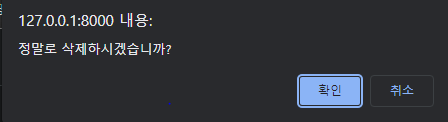

* 추가적으로 글을 작성하거나 수정, 삭제 도중 게시판의 목록으로 바로 돌아가고자 할때 게시판 바로가기 아이콘을 만들어 줄 수 있다.

In [ ]:
# templates/navbar.html에서 추가해준다
# 로그아웃, 로그인 버튼 위에 생성해준다
<li class="nav-item">
    <!-- 목록으로 바로가기 아이콘 생성 -->
    <a class="nav-link" href="{% url 'bbsnote:index' %}">bbsnote</a>
</li>